In [1]:
%%capture
pip install keras-preprocessing

In [2]:
from prettytable import PrettyTable
import numpy as np
import pandas as pd
import os

import random
import shutil

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
from skimage import io
from PIL import Image

import pathlib
import tensorflow as tf

import tensorflow as tf
from keras.layers import Dense, Flatten
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint

import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

In [3]:
%%capture
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-08-28 14:30:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: 'helper_functions.py'

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-08-28 14:30:19 (42.8 MB/s) - 'helper_functions.py' saved [10246/10246]



In [5]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [6]:
def TotalImages(path):
    src = os.listdir(path)
    data = []
    
    for lb in src:
        x = os.path.join(path, lb)
        y = os.listdir(x)
        data.append([lb, len(y)])
    
    table = tabulate(data, headers=['Label', 'Number of Images'], tablefmt='fancy_grid')
    
    print(table)

In [7]:
dataset_path = '/kaggle/input/sea-animals-image-dataste'

In [8]:
labels = os.listdir(dataset_path)

In [9]:
table = PrettyTable()
table.add_column('Labels', labels)

In [10]:
table.align = 'l'
print(table)

+-----------------+
| Labels          |
+-----------------+
| Penguin         |
| Clams           |
| Lobster         |
| Otter           |
| Eel             |
| Corals          |
| Puffers         |
| Squid           |
| Whale           |
| Sea Urchins     |
| Crabs           |
| Starfish        |
| Seal            |
| Octopus         |
| Shrimp          |
| Sharks          |
| Sea Rays        |
| Fish            |
| Seahorse        |
| Nudibranchs     |
| Dolphin         |
| Turtle_Tortoise |
| Jelly Fish      |
+-----------------+


In [11]:
TotalImages(dataset_path)

╒═════════════════╤════════════════════╕
│ Label           │   Number of Images │
╞═════════════════╪════════════════════╡
│ Penguin         │                482 │
├─────────────────┼────────────────────┤
│ Clams           │                497 │
├─────────────────┼────────────────────┤
│ Lobster         │                499 │
├─────────────────┼────────────────────┤
│ Otter           │                500 │
├─────────────────┼────────────────────┤
│ Eel             │                497 │
├─────────────────┼────────────────────┤
│ Corals          │                500 │
├─────────────────┼────────────────────┤
│ Puffers         │                531 │
├─────────────────┼────────────────────┤
│ Squid           │                483 │
├─────────────────┼────────────────────┤
│ Whale           │                572 │
├─────────────────┼────────────────────┤
│ Sea Urchins     │                579 │
├─────────────────┼────────────────────┤
│ Crabs           │                499 │
├───────────────

In [12]:
src = os.listdir(dataset_path)
data = []

for lb in src:
    x = os.path.join(dataset_path, lb)
    y = os.listdir(x)
    data.append(len(y))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


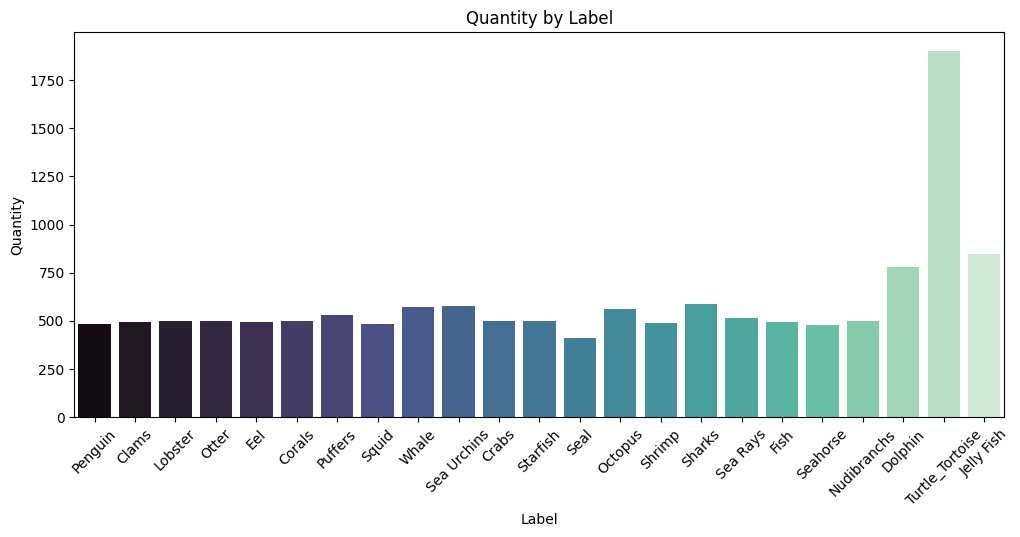

In [13]:
plt.figure(figsize=(12,5))
sns.barplot(x=labels, y=data, palette='mako')

plt.title('Quantity by Label')
plt.xlabel('Label')
plt.ylabel('Quantity')
plt.xticks(rotation=45)

plt.show()

In [14]:
def remove_directory(directory_path):
    for root, dirs, files in os.walk(directory_path, topdown=False):
        for file in files:
            file_path = os.path.join(root, file)
            os.remove(file_path)
            
        for dir in dirs:
            dir_path = os.path.join(root, dir)
            shutil.rmtree(dir_path)
    
    shutil.rmtree(directory_path)

In [15]:
directory_path = '/kaggle/working/sea-animals-image-datase'

In [16]:
output_path = '/kaggle/working/sea-animals-image-datase/'

In [17]:
if not os.path.exists(output_path):
    os.mkdir(os.path.join(output_path))

for label in labels:
    new_path = os.path.join(dataset_path, label)
    
    label_path = os.listdir(new_path)    
    
    ims = [i for i in label_path if i.endswith(".jpg")]
    
    random.shuffle(ims)
    split_size = 0.8
    train_len = int(len(ims) * split_size)
    train_ims = ims[:train_len]
    val_ims = ims[train_len:]
    
    # create train and val dirs
    train_path = os.path.join(output_path, "train")
    label_train_path = os.path.join(train_path, label)
    

    val_path = os.path.join(output_path, "val")
    label_val_path = os.path.join(val_path, label)
    
    if not os.path.exists(train_path):
        os.mkdir(train_path)
        
    if not os.path.exists(label_train_path):
        os.mkdir(label_train_path)
        
    if not os.path.exists(val_path):
        os.mkdir(val_path)  
    
    if not os.path.exists(label_val_path):
        os.mkdir(label_val_path)
    
    
    for im in train_ims:        
        shutil.copy(os.path.join(new_path, im), label_train_path)
    
    for im in val_ims:
        shutil.copy(os.path.join(new_path, im), label_val_path)

In [18]:
train_path = "/kaggle/working/sea-animals-image-datase/train"
TotalImages(train_path)

╒═════════════════╤════════════════════╕
│ Label           │   Number of Images │
╞═════════════════╪════════════════════╡
│ Crabs           │                397 │
├─────────────────┼────────────────────┤
│ Sea Urchins     │                462 │
├─────────────────┼────────────────────┤
│ Lobster         │                398 │
├─────────────────┼────────────────────┤
│ Sea Rays        │                413 │
├─────────────────┼────────────────────┤
│ Seal            │                329 │
├─────────────────┼────────────────────┤
│ Otter           │                399 │
├─────────────────┼────────────────────┤
│ Sharks          │                469 │
├─────────────────┼────────────────────┤
│ Dolphin         │                619 │
├─────────────────┼────────────────────┤
│ Corals          │                398 │
├─────────────────┼────────────────────┤
│ Puffers         │                424 │
├─────────────────┼────────────────────┤
│ Shrimp          │                390 │
├───────────────

In [19]:
val_path = "/kaggle/working/sea-animals-image-datase/val"
TotalImages(val_path)

╒═════════════════╤════════════════════╕
│ Label           │   Number of Images │
╞═════════════════╪════════════════════╡
│ Crabs           │                100 │
├─────────────────┼────────────────────┤
│ Sea Urchins     │                116 │
├─────────────────┼────────────────────┤
│ Lobster         │                100 │
├─────────────────┼────────────────────┤
│ Sea Rays        │                104 │
├─────────────────┼────────────────────┤
│ Seal            │                 83 │
├─────────────────┼────────────────────┤
│ Otter           │                100 │
├─────────────────┼────────────────────┤
│ Sharks          │                118 │
├─────────────────┼────────────────────┤
│ Dolphin         │                155 │
├─────────────────┼────────────────────┤
│ Corals          │                100 │
├─────────────────┼────────────────────┤
│ Puffers         │                106 │
├─────────────────┼────────────────────┤
│ Shrimp          │                 98 │
├───────────────

In [20]:
TARGET_SIZE = (224, 224)

In [21]:
datagen = ImageDataGenerator(        
            width_shift_range=0.2,  
            height_shift_range=0.2,    
            brightness_range = (0.3, 0.9),
            zoom_range=0.2)

In [22]:
def Augmentation(path, capacity):
    for label in labels:
        if label == 'Turtle_Tortoise':
            continue
            
        image_directory = path + '/' + label + '/'
        SIZE = TARGET_SIZE[0]
        dataset = []

        print(image_directory)
        my_images = os.listdir(image_directory)
        for i, image_name in enumerate(my_images):    
            if ((image_name.split('.')[1] == 'jpg')):
                image = load_img(image_directory + image_name, target_size = TARGET_SIZE)
                image = img_to_array(image)
                dataset.append(image)

        x = np.array(dataset)
        i = 0
        for batch in datagen.flow(x, batch_size=16,
                                save_to_dir= train_path + '/' + label + '/',
                                save_prefix='aug',
                                save_format='jpg'):
            i += 1    
            if i > capacity:        
                break

In [23]:
Augmentation(train_path, 50)
Augmentation(val_path, 50)

/kaggle/working/sea-animals-image-datase/train/Penguin/
/kaggle/working/sea-animals-image-datase/train/Clams/
/kaggle/working/sea-animals-image-datase/train/Lobster/
/kaggle/working/sea-animals-image-datase/train/Otter/
/kaggle/working/sea-animals-image-datase/train/Eel/
/kaggle/working/sea-animals-image-datase/train/Corals/
/kaggle/working/sea-animals-image-datase/train/Puffers/
/kaggle/working/sea-animals-image-datase/train/Squid/
/kaggle/working/sea-animals-image-datase/train/Whale/
/kaggle/working/sea-animals-image-datase/train/Sea Urchins/
/kaggle/working/sea-animals-image-datase/train/Crabs/
/kaggle/working/sea-animals-image-datase/train/Starfish/
/kaggle/working/sea-animals-image-datase/train/Seal/
/kaggle/working/sea-animals-image-datase/train/Octopus/
/kaggle/working/sea-animals-image-datase/train/Shrimp/
/kaggle/working/sea-animals-image-datase/train/Sharks/
/kaggle/working/sea-animals-image-datase/train/Sea Rays/
/kaggle/working/sea-animals-image-datase/train/Fish/
/kaggle/w

In [24]:
TotalImages(train_path)

╒═════════════════╤════════════════════╕
│ Label           │   Number of Images │
╞═════════════════╪════════════════════╡
│ Crabs           │               1939 │
├─────────────────┼────────────────────┤
│ Sea Urchins     │               2020 │
├─────────────────┼────────────────────┤
│ Lobster         │               1942 │
├─────────────────┼────────────────────┤
│ Sea Rays        │               1986 │
├─────────────────┼────────────────────┤
│ Seal            │               1843 │
├─────────────────┼────────────────────┤
│ Otter           │               1945 │
├─────────────────┼────────────────────┤
│ Sharks          │               2028 │
├─────────────────┼────────────────────┤
│ Dolphin         │               2221 │
├─────────────────┼────────────────────┤
│ Corals          │               1942 │
├─────────────────┼────────────────────┤
│ Puffers         │               2005 │
├─────────────────┼────────────────────┤
│ Shrimp          │               1904 │
├───────────────

In [25]:
TotalImages(val_path)

╒═════════════════╤════════════════════╕
│ Label           │   Number of Images │
╞═════════════════╪════════════════════╡
│ Crabs           │                100 │
├─────────────────┼────────────────────┤
│ Sea Urchins     │                116 │
├─────────────────┼────────────────────┤
│ Lobster         │                100 │
├─────────────────┼────────────────────┤
│ Sea Rays        │                104 │
├─────────────────┼────────────────────┤
│ Seal            │                 83 │
├─────────────────┼────────────────────┤
│ Otter           │                100 │
├─────────────────┼────────────────────┤
│ Sharks          │                118 │
├─────────────────┼────────────────────┤
│ Dolphin         │                155 │
├─────────────────┼────────────────────┤
│ Corals          │                100 │
├─────────────────┼────────────────────┤
│ Puffers         │                106 │
├─────────────────┼────────────────────┤
│ Shrimp          │                 98 │
├───────────────

In [26]:
train_dataset_url = train_path
train_data_dir = pathlib.Path(train_dataset_url)

In [27]:
validation_dataset_url = val_path
validation_data_dir = pathlib.Path(validation_dataset_url)

In [28]:
img_height,img_width= TARGET_SIZE
batch_size=32

In [29]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 45140 files belonging to 23 classes.


In [30]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  validation_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2743 files belonging to 23 classes.


In [31]:
def plot_images(dataset):
    plt.figure(figsize=(6,6))
    
    for images, labels in train_ds.take(1):
        for i in range(6):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis("off")

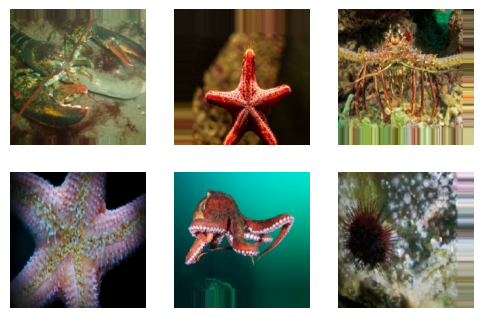

In [32]:
plot_images(train_ds)

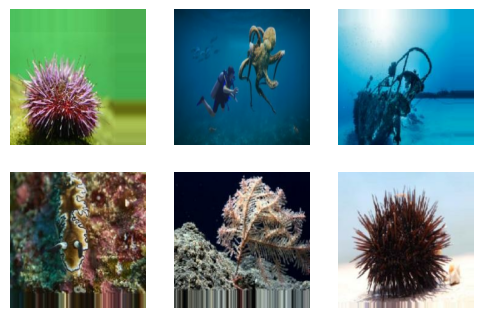

In [33]:
plot_images(val_ds)

In [34]:
model = Sequential([
    layers.Conv2D(64, (5,5), activation='relu', padding= 'valid', input_shape=(224,224,3)),
    layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.2),
    BatchNormalization(),
    
    layers.Conv2D(128, (5,5), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.2),
    BatchNormalization(),
    
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.2),
    BatchNormalization(),
    
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.2),
    BatchNormalization(),
    
    layers.Conv2D(1024, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(len(labels), activation='softmax'),
])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 220, 220, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 110, 110, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 106, 106, 128)  │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 53, 53, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 53, 53, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 51, 51, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 25, 25, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 23, 23, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 11, 11, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 9, 9, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 23)             │        11,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,809,495 (56.49 MB)

 Trainable params: 14,807,575 (56.49 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [35]:
checkpoint_path = "animals_classification_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, save_weights_only=True)

In [36]:
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 5,
                               restore_best_weights = True)

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_ds,
    steps_per_epoch=len(train_ds),
    validation_data=val_ds,
    validation_steps=len(val_ds),
    
    epochs=30,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "animal_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/animal_classification/20240828-144038
Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


  55/1411 ━━━━━━━━━━━━━━━━━━━━ 3:48:57 10s/step - accuracy: 0.0594 - loss: 17.7279

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train'])
plt.show()

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['validation'])
plt.show()

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()